#### **Load required libraries**

In [1]:
# Libraries
import ee
import geemap
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Earth Engine authentication and initialization
try:

    ee.Initialize()

except:

    ee.Authenticate()
    ee.Initialize()

print('Libraries successfully loaded')

Libraries successfully loaded


#### **Imagery filtering**

In [2]:
# Set area of interest (AOI)
aoi = ee.Geometry.Rectangle([-57.930, -17.657, -57.570, -17.400])

# Import cloud probability data set
clouds = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
          .filterBounds(aoi)
          .filter(ee.Filter.contains('.geo', aoi)))

# Import collection
coll = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
        .filterBounds(aoi)
        .filter(ee.Filter.contains('.geo', aoi))
        .filter(ee.Filter.lte('GENERAL_QUALITY', 'PASSED'))
        .filter(ee.Filter.stringContains('PRODUCT_ID', 'OPER').Not())
        .combine(clouds))

# Define cloudy pixels (probability greater than or equal to 65%)
coll = coll.map(
    lambda image: 
        image.addBands(image
                       .select('probability')
                       .gte(65)
                       .rename('clouds'))
    )

# Retrieve proportion of clouds within the AOI
def cloudiness(image):

    cloudiness = image.select('clouds').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=10,
        maxPixels=1e9
    )
        
    return image.set(cloudiness).updateMask(image.select('clouds').Not())

# Map function and get images with cloud coverage less than or equal to 5%
coll = coll.map(cloudiness).filter(ee.Filter.lte('clouds', 0.05))

print('Number of scenes: ', coll.size().getInfo())

Number of scenes:  205


Visualization of the region:

In [3]:
Map = geemap.Map()
Map.addLayer(coll.first(),
            {'bands': ['B4', 'B8', 'B2'],
            'min':0, 'max': 3500}, 'True Color')
Map.addLayer(aoi)
Map.centerObject(aoi, 12)
Map

Map(center=[-17.52855086053025, -57.75000000000028], controls=(WidgetControl(options=['position', 'transparent…

#### **Generation of water surface extent (WSE)**

In [3]:
# Function to get water extent based on Normalized Difference Water Index (NDWI)
def water_extent(image):
  
    # Calculate NDWI
    ndwi = image.normalizedDifference(['B3', 'B8'])

    # Define water area based on a NDWI threshold
    water = ndwi.gte(0).rename('water')

    # Return image with the new bands
    return image.addBands(water)

# Map function over the collection
coll = coll.map(water_extent)

#### **Extraction of water surface extent**

In [4]:
# Function to extract number of water pixels
def water_area(image, start_list):

    # Initialize list
    area_list = ee.List(start_list)

    # Get sum (number of water pixels)
    water_area = image.select('water').reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=10,
        maxPixels=1e9
    )

    # Update list with area in square kilometers
    return area_list.add([image.date().format(),
                          water_area.getNumber('water').divide(1e4)])

# Iterate over the collection
wse = coll.iterate(water_area, [])

Generate a dataframe with water surface extent values for the period:

In [8]:
# Create dataframe
wse_df = pd.DataFrame(wse.getInfo())

# Rename columns and get datetimes
wse_df.columns = ['date', 'area']
wse_df['date'] = pd.to_datetime(wse_df.date)
wse_df['year'] = wse_df.date.dt.year

# Remove outliers (errors)
wse_df = wse_df[wse_df.area > 200]

#### **Visualization**

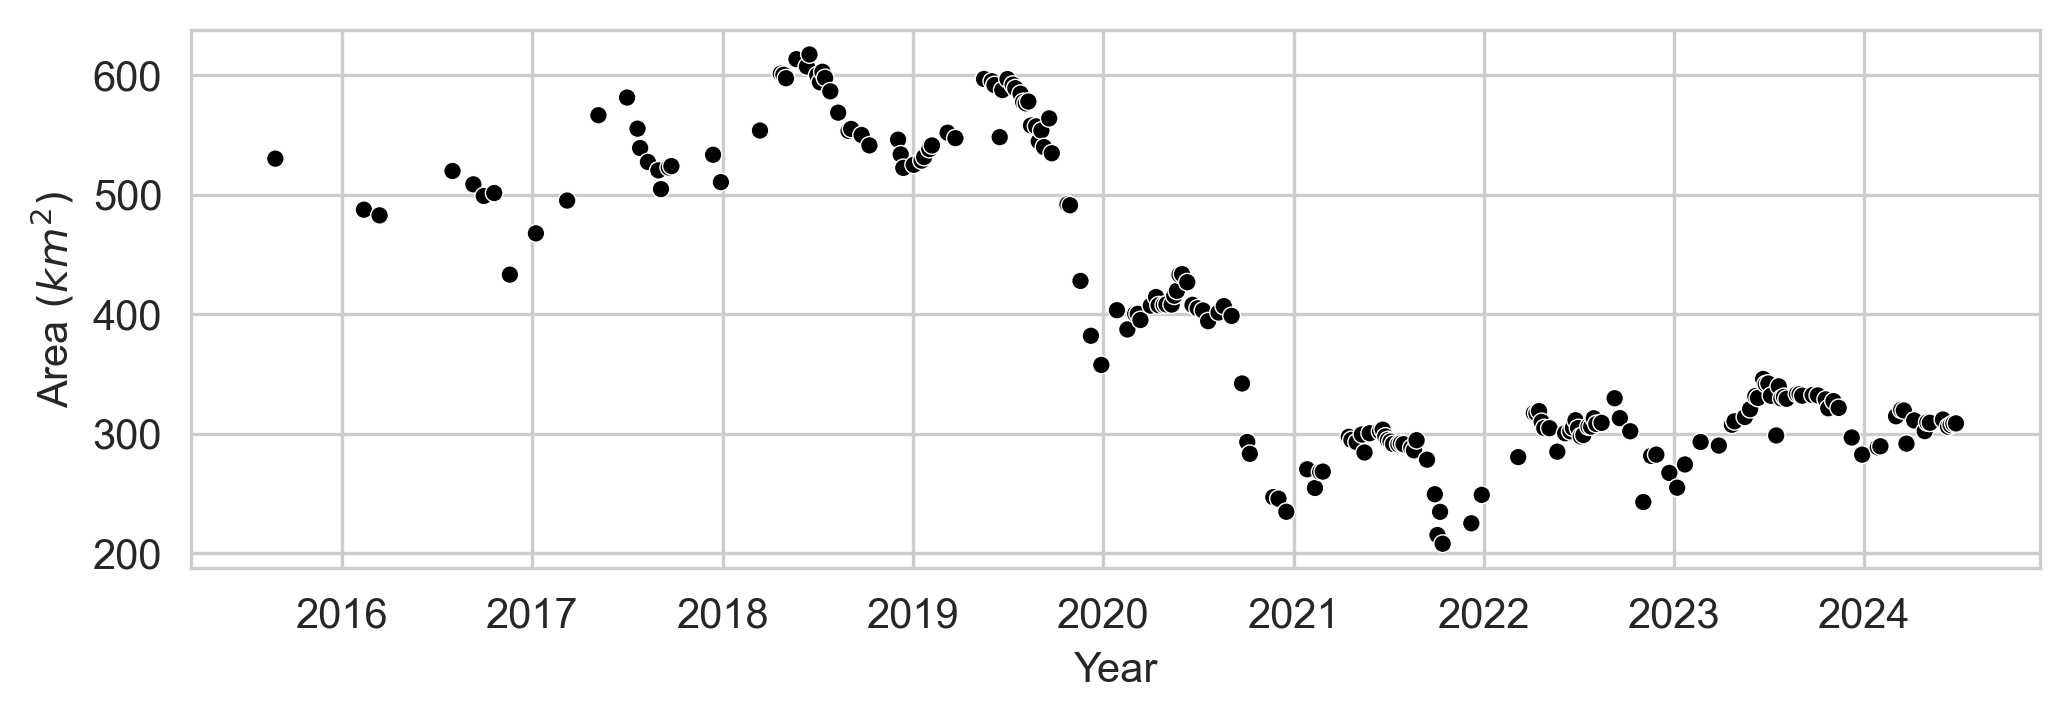

In [23]:
# Create figure
plt.figure(figsize=(7, 2.5), dpi=300)
sns.set_style('whitegrid')

# Scatterplot 
plot = sns.scatterplot(data=wse_df,
                       x='date',
                       y='area',
                       size=0.5,
                       color='black',
                       legend=False)

# Axes labels
plot.set_xlabel('Year');
plot.set_ylabel('Area $(km^2)$');

# Save figure
plt.tight_layout()
plt.savefig('scatter_area.tif')

Generate median scenes and save to Google Drive:

In [5]:
# Median scenes
median1520 = coll.filterDate('2015-01-01', '2020-12-31').median().select(['B4', 'B8', 'B2', 'water'])
median2124 = coll.filterDate('2021-01-01', '2024-06-25').median().select(['B4', 'B8', 'B2', 'water'])

# Export to Drive
geemap.ee_export_image_to_drive(median1520, description="median1520",
                                folder="scenes_pantanal", region=aoi, scale=10)

geemap.ee_export_image_to_drive(median2124, description="median2124",
                                folder="scenes_pantanal", region=aoi, scale=10)